# Personal Metrics

This note book is an aggregate of personal health and fitness metrics.

# Pfitz Workout Heart Rate Ranges

This is based off percentages of heart rate reserve calculated using weekly avg resting heart rate and max heart rate.

In [1]:
import pandas

maxHeartRate = 196
restingHeartRate = 54

In [5]:
def printPfitzHeartRateReserveChart(resting,max):
    percentageOfHeartRateReserve = {}
    percentageOfHeartRateReserve['v02'] = (92,97)
    percentageOfHeartRateReserve['Lactate Threshold'] = (75,88)
    percentageOfHeartRateReserve['Endurance'] = (65,78)
    percentageOfHeartRateReserve['General Aerobic'] = (62,75)
    percentageOfHeartRateReserve['Recovery'] = (0,70)

    tableData = []
    for workout in percentageOfHeartRateReserve:
        tableData.append([round(((max-resting)*(percentageOfHeartRateReserve[workout][0]/100))+resting),round(((max-resting)*(percentageOfHeartRateReserve[workout][1]/100))+resting)])
    workoutHeaders = ['v02', 'Lactate Threshold', 'Endurance', 'General Aerobic', 'Recovery']
    columnHeaders = ['min', 'max']
    print(pandas.DataFrame(tableData, workoutHeaders, columnHeaders))
    # print('--------------------------')
    # for workout in percentageOfHeartRateReserve:
    #     print('|  {0}  |    {1} - {2}   |'.format(workout,round(((max-resting)*(percentageOfHeartRateReserve[workout][0]/100))+resting),round(((max-resting)*(percentageOfHeartRateReserve[workout][1]/100))+resting)))
    # print('--------------------------')

printPfitzHeartRateReserveChart(restingHeartRate, maxHeartRate)

                   min  max
v02                185  192
Lactate Threshold  160  179
Endurance          146  165
General Aerobic    142  160
Recovery            54  153


# Setup Strave OAuth access token

In [1]:
import webbrowser
import config
import threading
import time
import requests

from http.server import BaseHTTPRequestHandler, HTTPServer
from urllib.parse import urlparse, parse_qs

stravaCode = None
httpd = None

def stravaCodeWatcher():
    global stravaCode
    global httpd
    while True:
        print('Checking Strava access token')
        if stravaCode is not None:
            print('shutting down web server')
            httpd.shutdown()
            return
        time.sleep(5)

watcher_thread = threading.Thread(target=stravaCodeWatcher)
# watcher_thread.daemon = True

# Start the thread
watcher_thread.start()

# Define the request handler class
class MyRequestHandler(BaseHTTPRequestHandler):
    def do_GET(self):
        # Parse the query string parameters
        query_params = parse_qs(urlparse(self.path).query)
        
        # Check if the 'code' parameter exists in the query string
        if 'code' in query_params:
            code = query_params['code'][0]
            global stravaCode
            print('setting strava access token')
            stravaCode = code
            self.send_response(200)
            self.send_header('Content-type', 'text/plain')
            self.end_headers()
            self.wfile.write(f'Query Parameter "code" Value: {code}'.encode('utf-8'))
            return
        else:
            self.send_response(400)
            self.send_header('Content-type', 'text/plain')
            self.end_headers()
            self.wfile.write('Missing "code" parameter in query string'.encode('utf-8'))
            return

# Create an HTTP server with the custom request handler
def run(server_class=HTTPServer, handler_class=MyRequestHandler, port=3000):
    server_address = ('', port)
    global httpd
    httpd = server_class(server_address, handler_class)
    print(f'Starting server on port {port}...')
    httpd.serve_forever()

def getAccessTokenWithCode(client_id, client_secret, code):
    # Define the URL for the GET request
    url = "https://www.strava.com/oauth/token?client_id={}&client_secret={}&code={}&grant_type=authorization_code".format(client_id, client_secret, code)
    print
    response = requests.post(url)
    if response.status_code == 200:
        try:
            response_json = response.json()
            access_token = response_json.get("access_token")
            if access_token:
                return access_token
            else:
                print("Access token not found in the response JSON.")
        except ValueError:
            print("Failed to parse JSON response.")
    else:
        print(f"Request failed with status code: {response.status_code}")

#set up a listener on 3000 parse token and post to get access token then update strava access token and print that it has been set up

webbrowser.open("https://www.strava.com/oauth/authorize?client_id={}&response_type=code&redirect_uri=http://localhost:3000/exchange_token&approval_prompt=force&scope=activity:read_all".format(config.config['client_id']))

run()

stravaAccessToken = getAccessTokenWithCode(config.config['client_id'], config.config['client_secret'], stravaCode)

print(stravaAccessToken)

Checking Strava access token
Starting server on port 3000...
Checking Strava access token
setting strava access token


127.0.0.1 - - [16/Sep/2023 14:26:47] "GET /exchange_token?state=&code=78fa04d0942ac55c21fdb8e6e47b953e3dc8e1e1&scope=read,activity:read_all HTTP/1.1" 200 -
127.0.0.1 - - [16/Sep/2023 14:26:47] "GET /favicon.ico HTTP/1.1" 400 -


setting strava access token


127.0.0.1 - - [16/Sep/2023 14:26:48] "GET /exchange_token?state=&code=78fa04d0942ac55c21fdb8e6e47b953e3dc8e1e1&scope=read,activity:read_all HTTP/1.1" 200 -
127.0.0.1 - - [16/Sep/2023 14:26:49] "GET /favicon.ico HTTP/1.1" 400 -


Checking Strava access token
shutting down web server
setting strava access token
1ce32628828e91489d25e17e034d0aa93da02ca8


127.0.0.1 - - [16/Sep/2023 14:26:55] "GET /exchange_token?state=&code=78fa04d0942ac55c21fdb8e6e47b953e3dc8e1e1&scope=read,activity:read_all HTTP/1.1" 200 -


# Weekly Mileage Chart

In [2]:
import requests
import datetime
import pandas as pd

accessToken = stravaAccessToken

def getAllRuns(access_token):
    # Get the start and end date of the current week.
    today = datetime.date.today()
    start_date = today - datetime.timedelta(days=today.weekday())
    end_date = start_date - datetime.timedelta(days=731)

    runs = []
    page = 1
    # Get the activities for the current week.
    while True:
        url = "https://www.strava.com/api/v3/activities?start_date={start_date}&end_date={end_date}&per_page=100&page={page}".format(
            start_date=end_date, end_date=today, page=page
        )
        response = requests.get(url, headers={"Authorization": "Bearer {}".format(access_token)})
        activities = response.json()
        print(activities)
        runs = runs + activities
        if(len(activities) < 1):
            break
        page += 1

    onlyRuns = [activity for activity in runs if activity["sport_type"] == "Run"]
    return onlyRuns

runs = getAllRuns(accessToken)

[{'resource_state': 2, 'athlete': {'id': 41502875, 'resource_state': 1}, 'name': 'Evening Run', 'distance': 33875.0, 'moving_time': 10720, 'elapsed_time': 11472, 'total_elevation_gain': 107.0, 'type': 'Run', 'sport_type': 'Run', 'workout_type': 0, 'id': 9857158114, 'start_date': '2023-09-15T22:07:51Z', 'start_date_local': '2023-09-15T18:07:51Z', 'timezone': '(GMT-05:00) America/New_York', 'utc_offset': -14400.0, 'location_city': None, 'location_state': None, 'location_country': None, 'achievement_count': 1, 'kudos_count': 2, 'comment_count': 0, 'athlete_count': 1, 'photo_count': 0, 'map': {'id': 'a9857158114', 'summary_polyline': 'albtFt}{cM_CL{EiCeAV]pGdFtCHzAcAfEg@f@yEmCfBuHdE`BVpB_A~Dg@l@}KmFgAyAtAoGu@{O^y@zCMl@xE`@d@|GSz@nCdA\\tD}EBkAu@oCp@oBk@p@EnAvBpIcDxEuA`@gHwC}DfAQu@dA}EYeEaAq@yAFwApAl@`OkAnGF~@hB~AdKtEj@c@pAmFi@}AmE_C\\gG`J`DdLwLnIoCzC]rDvFbB\\bDwDnDyBR_AkAmBoCLiHbIz@xBvANzCaD|C_BvDaEvBkG?iEtAuCKm@_BqDkA{F{@y@oSnDy@dBr@rGyAl@Ux@rAzIoBn@_C}Ju@McCx@e@nATtEOfAqJbB]pA|@xE_E|EaA[a

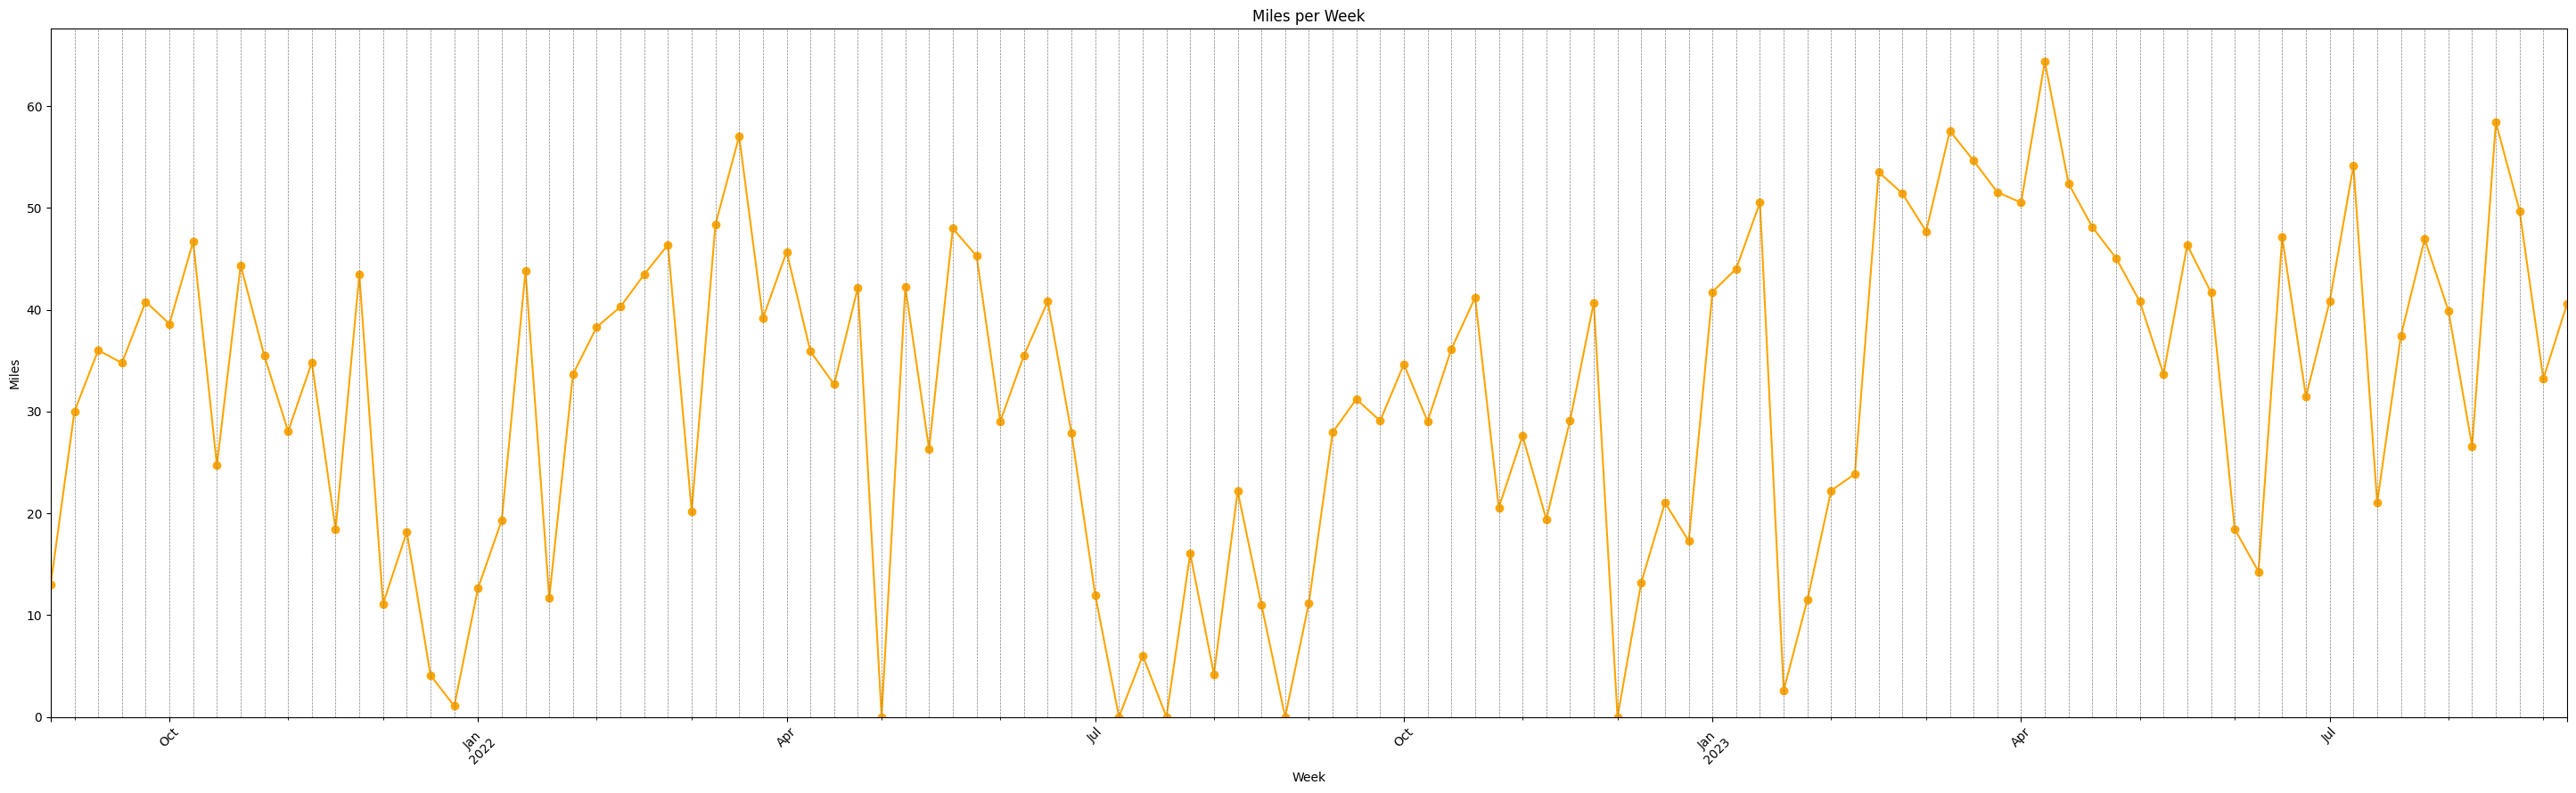

In [3]:
import matplotlib.pyplot as plt

df = pd.DataFrame([activity for activity in runs if int(activity["start_date_local"][:4]) > 2019])

df['distance'] = df['distance'] * 0.000621371

df['start_date_local'] = pd.to_datetime(df['start_date_local']) - pd.to_timedelta(7, unit='d')

grouped_df = df.groupby([pd.Grouper(key='start_date_local', freq='W-SUN')])['distance'].sum()

grouped_df.plot(kind='line', figsize=(29,9), color='orange', marker='o')
plt.xlabel('Week')
plt.ylabel('Miles')
plt.ylim(0, None) 
plt.title('Miles per Week')
plt.xticks(rotation=45)
plt.tight_layout()

for index in grouped_df.index:
    plt.axvline(index, color='gray', linestyle='--', linewidth=0.5)

# plt.fill_between(index, color='lightblue')

plt.show()


# Garmin Data

In [4]:
#Update GarminDB
import subprocess
command = "garmindb_cli.py --all --download --import --analyze --latest" 

try:
    # Run the command and capture its output and error
    completed_process = subprocess.run(command, shell=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    
    # Check if the command was successful (return code 0)
    if completed_process.returncode == 0:
        # Print the standard output
        print("Standard Output:")
        print(completed_process.stdout)
    else:
        # Print the standard error if the command failed
        print("Command Failed with Error:")
        print(completed_process.stderr)
except Exception as e:
    print(f"An error occurred: {str(e)}")

Standard Output:
___Downloading Latest Data___
Getting activities: '/home/cbyst/HealthData/FitFiles/Activities' (25) temp /tmp/tmpicn4afde
___Importing Latest Data___
Processing profile data
Processing [<FileType.settings: 2>] FIT data from /home/cbyst/HealthData/FitFiles
Processing weight data
Processing daily summary data
Processing [<FileType.monitoring_b: 32>] FIT data from /home/cbyst/HealthData/FitFiles/Monitoring
Processing sleep data
Processing rhr data
Processing activities tcx data
Processing latest activities summary data from /home/cbyst/HealthData/FitFiles/Activities
Processing activities detail data
Processing [<FileType.activity: 4>] FIT data from /home/cbyst/HealthData/FitFiles/Activities
___Analyzing Data___
Summary Tables Generation:
Generating table entries for 2021
Generating table entries for 2022
Generating table entries for 2023



In [5]:
from garmindb import ConfigManager, Graph
from garmindb.garmindb import GarminSummaryDb, DaysSummary, MonitoringDb, MonitoringHeartRate
from garmindb.summarydb import DaysSummary, WeeksSummary, MonthsSummary, SummaryDb


start_ts = datetime.datetime.combine(datetime.date(year=2017, month=1, day=1), datetime.datetime.min.time())
end_ts = datetime.datetime.combine(datetime.date.today(), datetime.datetime.max.time())

db_params = ConfigManager.get_db_params()
sum_db = SummaryDb(db_params, False)
data = DaysSummary.get_for_period(sum_db, start_ts, end_ts, DaysSummary)
time = [entry.day for entry in data]
hr_avg = [entry.hr_avg for entry in data]
hr_min = [entry.hr_min for entry in data]
hr_max = [entry.hr_max for entry in data]
rhr_avg = [entry.rhr_avg for entry in data]
rhr_min = [entry.rhr_min for entry in data]
rhr_max = [entry.rhr_max for entry in data]
inactive_hr_avg = [entry.inactive_hr_avg for entry in data]
inactive_hr_min = [entry.inactive_hr_min for entry in data]
inactive_hr_max = [entry.inactive_hr_max for entry in data]

hr_df = pd.DataFrame([time, hr_avg, hr_min, hr_max, rhr_avg, rhr_min, rhr_max,
                      inactive_hr_avg, inactive_hr_min, inactive_hr_max]).T
hr_df.columns = ["Date", "hr_avg", "hr_min", "hr_max", "rhr_avg", "rhr_min", "rhr_max",
                 "inactive_hr_avg", "inactive_hr_min", "inactive_hr_max"]
hr_df

,Date,hr_avg,hr_min,hr_max,rhr_avg,rhr_min,rhr_max,inactive_hr_avg,inactive_hr_min,inactive_hr_max
0,2021-09-09,73.320175,57.0,103.0,63.0,63.0,63.0,71.125,60.0,90.0
1,2021-09-10,73.553746,54.0,110.0,59.0,59.0,59.0,70.571429,59.0,87.0
2,2021-09-11,98.148148,59.0,177.0,63.0,63.0,63.0,80.294118,62.0,124.0
3,2021-09-12,98.313253,64.0,173.0,67.0,67.0,67.0,85.777778,64.0,116.0
4,2021-09-13,94.497238,54.0,181.0,61.0,61.0,61.0,75.875,64.0,87.0
...,...,...,...,...,...,...,...,...,...,...
733,2023-09-12,79.850633,54.0,180.0,57.0,57.0,57.0,65.266667,56.0,124.0
734,2023-09-13,78.393414,44.0,183.0,59.0,59.0,59.0,74.423077,56.0,121.0
735,2023-09-14,74.633362,49.0,174.0,60.0,60.0,60.0,69.075,56.0,88.0
736,2023-09-15,83.151724,48.0,171.0,58.0,58.0,58.0,69.974359,58.0,103.0


In [7]:
from operator    import itemgetter
from collections import namedtuple

def smooth(time, data, alpha=1, today=None):
    """Perform exponential smoothing with factor `alpha`.

    Time period is a day.
    Each time period the value of `hr` drops `alpha` times.
    The most recent data is the most valuable one.
    """
    assert 0 < alpha <= 1

    if alpha == 1: # no smoothing
        return sum(data) / len(data)

    if today is None:
        today = max(time)

    numerator = sum(alpha**((today - date).days) * hr for date, hr in zip(time, data) if not (date > today))
    denom = sum(alpha**((today - date).days) for date, hr in zip(time, data) if not (date > today))
        
    return numerator / denom

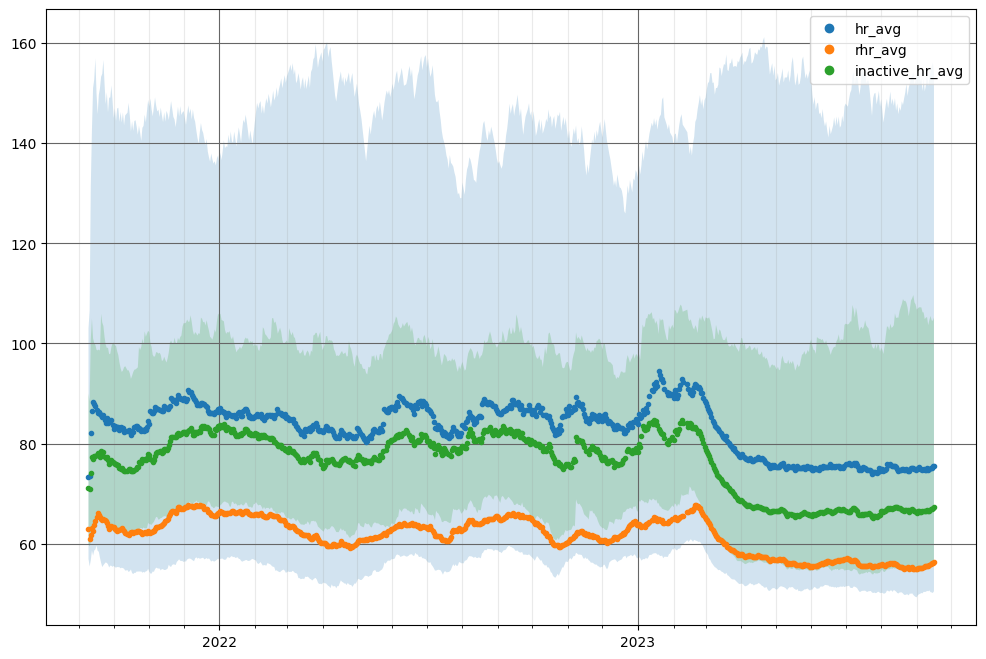

In [8]:
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

alpha = 0.95

color = ['r', 'g', 'b']

columns = ["hr_avg", "rhr_avg", "inactive_hr_avg"]

for col in columns:
    _df = hr_df[["Date", col, col.replace("avg", "min"), col.replace("avg", "max")]].dropna()
    smoothed_hr = [smooth(_df.Date,  _df[col], alpha=alpha, today=date) for date in _df.Date]
    smoothed_hr_max = [smooth(_df.Date,  _df[col.replace("avg", "min")], alpha=alpha, today=date) for date in _df.Date]
    smoothed_hr_min = [smooth(_df.Date,  _df[col.replace("avg", "max")], alpha=alpha, today=date) for date in _df.Date]

    plt.plot(list(_df.Date), smoothed_hr, 'o', ms=3.0, label=col)
    plt.fill_between(list(_df.Date), smoothed_hr_min, smoothed_hr_max, alpha=0.2)

plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.legend()

ax = plt.gca()
legend = ax.legend(frameon=True)
ax.legend(markerscale=2)

years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
# yearsFmt = plt.matplotlib.dates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
# ax.xaxis.set_major_formatter(yearsFmt)

plt.show()

In [9]:
weight_avg = [entry.weight_avg for entry in data]

weight_df = pd.DataFrame([time, weight_avg]).T
weight_df.columns = ["Date", "weight_avg"]
weight_df

,Date,weight_avg
0,2021-09-09,130.798078
1,2021-09-10,None
2,2021-09-11,None
3,2021-09-12,None
4,2021-09-13,None
...,...,...
733,2023-09-12,None
734,2023-09-13,None
735,2023-09-14,None
736,2023-09-15,140.196386


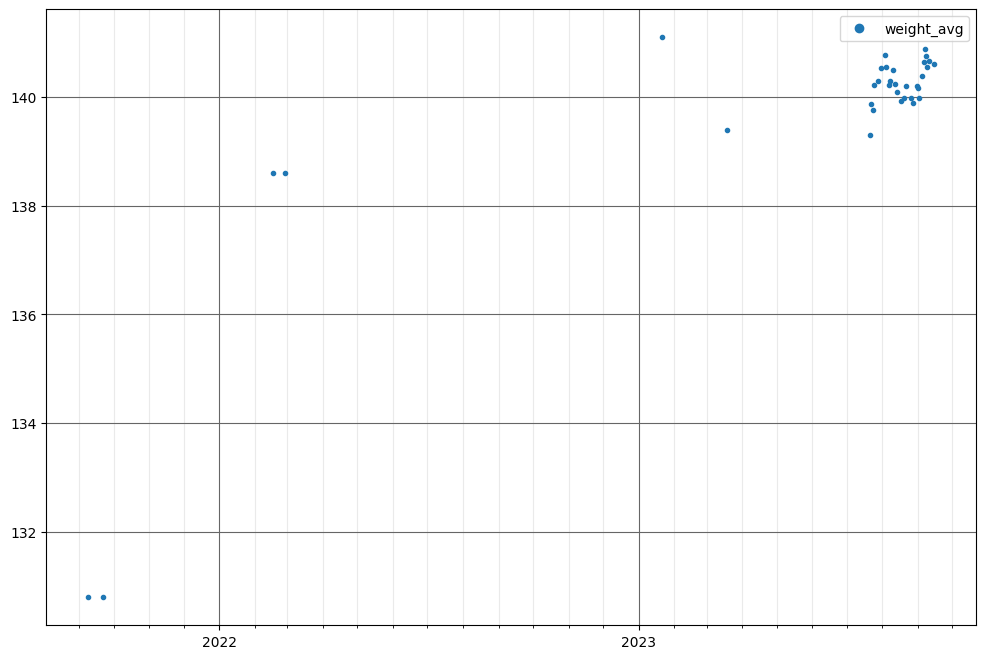

In [10]:
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

alpha = 0.95

color = ['r', 'g', 'b']

columns = ["weight_avg"]

for col in columns:
    _df = weight_df[["Date",col]].dropna()
    smoothed_weight = [smooth(_df.Date,  _df[col], alpha=alpha, today=date) for date in _df.Date]

    plt.plot(list(_df.Date), smoothed_weight, 'o', ms=3.0, label=col)
    # plt.fill_between(list(_df.Date), smoothed_hr_min, smoothed_hr_max, alpha=0.2)

plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.legend()

ax = plt.gca()
legend = ax.legend(frameon=True)
ax.legend(markerscale=2)

years = plt.matplotlib.dates.YearLocator()
months = plt.matplotlib.dates.MonthLocator()
# yearsFmt = plt.matplotlib.dates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
# ax.xaxis.set_major_formatter(yearsFmt)

plt.show()